In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16
import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
NOISE_DIM = 100  
BATCH_SIZE = 4 
STEPS_PER_EPOCH = 1750
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)

In [3]:
YES_DIR = "../input/brain-mri-images-for-brain-tumor-detection/yes"
NO_DIR = "../input/brain-mri-images-for-brain-tumor-detection/no"

In [4]:
def load_images(folder):
    
    imgs = []
    target = 1 if "yes" in folder.lower() else 0
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue
        
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [ ]:
def generate_and_save_images(generator, n_images=2000, output_dir="output", class_label=""):
    os.makedirs(output_dir, exist_ok=True)
    batch_size = 50
    n_batches = n_images // batch_size
    count = 0
    generated_images = []
    
    for i in tqdm(range(n_batches), desc=f"Generating {class_label} images"):
        noise = np.random.normal(0, 1, size=(batch_size, NOISE_DIM))
        gen_imgs = generator.predict(noise)
        
        for j, img in enumerate(gen_imgs):
            generated_images.append(img)
            
            img_save = ((img * 127.5) + 127.5).astype(np.uint8)
            img_save = img_save.reshape(WIDTH, HEIGHT)
            
          
            filename = os.path.join(output_dir, f"{class_label}_{count}.jpg")
            
           
            cv2.imwrite(filename, img_save)
            count += 1
    
    generated_images = np.array(generated_images)
    
    print(f"Successfully generated and saved {count} {class_label} images to '{output_dir}' directory.")
    print(f"Generated array shape: {generated_images.shape}")
    
    return generated_images

In [5]:
def train_and_generate(data_dir, output_dir, class_label):
    print(f"Loading {class_label} class images from {data_dir}...")
    data, labels = load_images(data_dir)
    print(f"Loaded {len(data)} images for {class_label} class")

    X_train = data
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = X_train.reshape(-1, WIDTH, HEIGHT, CHANNELS)
    
    print(f"Training data shape for {class_label} class: {X_train.shape}")
    
    
    plt.figure(figsize=(20,8))
    for i in range(min(10, len(X_train))):
        axs = plt.subplot(2,5,i+1)
        plt.imshow(X_train[i], cmap="gray")
        plt.axis('off')
        axs.set_xticklabels([])
        axs.set_yticklabels([])
        plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    plt.title(f"Sample {class_label} Images")
    plt.show()
    
    
    print(f"\nBuilding GAN for {class_label} class...")
    discriminator = build_discriminator()
    generator = build_generator()
    
    
    discriminator.trainable = False 
    gan_input = Input(shape=(NOISE_DIM,))
    fake_image = generator(gan_input)
    gan_output = discriminator(fake_image)
    gan = Model(gan_input, gan_output, name=f"gan_model_{class_label}")
    gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)
    
    print(f"Training GAN for {class_label} class...")
    
    np.random.seed(SEED)
    for epoch in range(EPOCHS):
        total_d_loss = 0
        total_g_loss = 0
        
        for batch in tqdm(range(STEPS_PER_EPOCH), desc=f"Epoch {epoch+1}/{EPOCHS}"):
            noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
            fake_X = generator.predict(noise)
            
            idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
            real_X = X_train[idx]

            X = np.concatenate((real_X, fake_X))

            disc_y = np.zeros(2*BATCH_SIZE)
            disc_y[:BATCH_SIZE] = 1

            d_loss = discriminator.train_on_batch(X, disc_y)
            
            y_gen = np.ones(BATCH_SIZE)
            g_loss = gan.train_on_batch(noise, y_gen)
            
            total_d_loss += d_loss
            total_g_loss += g_loss

        avg_d_loss = total_d_loss / STEPS_PER_EPOCH
        avg_g_loss = total_g_loss / STEPS_PER_EPOCH
        
        print(f"EPOCH: {epoch + 1} Generator Loss: {avg_g_loss:.4f} Discriminator Loss: {avg_d_loss:.4f}")
        
        
        if (epoch + 1) % 2 == 0 or epoch == EPOCHS - 1:
            noise = np.random.normal(0, 1, size=(10, NOISE_DIM))
            sample_images(generator, noise, (2,5), figsize=(22,8), title=f"{class_label} - Epoch {epoch+1}")
    
    
    print(f"Generating synthetic {class_label} images...")
    synthetic_images = generate_and_save_images(generator, 2000, output_dir, class_label)
    
    
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))
    sns.distplot(X_train, label=f'Real {class_label} Images', hist=True, ax=axs)
    sns.distplot(synthetic_images, label=f'Generated {class_label} Images', hist=True, ax=axs)
    axs.legend(loc='upper right', prop={'size': 12})
    plt.title(f"Distribution Comparison for {class_label} Class")
    plt.show()
    
    return synthetic_images

In [6]:
def build_generator():
    """
    Generator model that generates images using random noise. The random noise (Latent Vector)
    is sampled from a Normal Distribution and given as input to the Generator.
    """
    model = Sequential([
        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),
        
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ], 
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)
    return model

In [7]:
def build_discriminator():
    """
    Discriminator model that classifies generated images as fake or real.
    """
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)
    return model

In [8]:
def sample_images(generator, noise, subplots, figsize=(22,8), save=False, title=None):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save:
            img_name = f"gen_{title}_{i}"
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')
    
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
yes_output_dir = "/kaggle/working/yes"
no_output_dir = "/kaggle/working/no"
augmented_dir = "/kaggle/working/augmented_images"
results_dir = "/kaggle/working/results"
model_dir = "/kaggle/working/logs"

In [ ]:
for directory in [yes_output_dir, no_output_dir, augmented_dir,results_dir, model_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")


=== TRAINING YES CLASS (TUMOR) ===
Loading yes class images from ../input/brain-mri-images-for-brain-tumor-detection/yes...
Loaded 155 images for yes class
Training data shape for yes class: (155, 128, 128, 1)


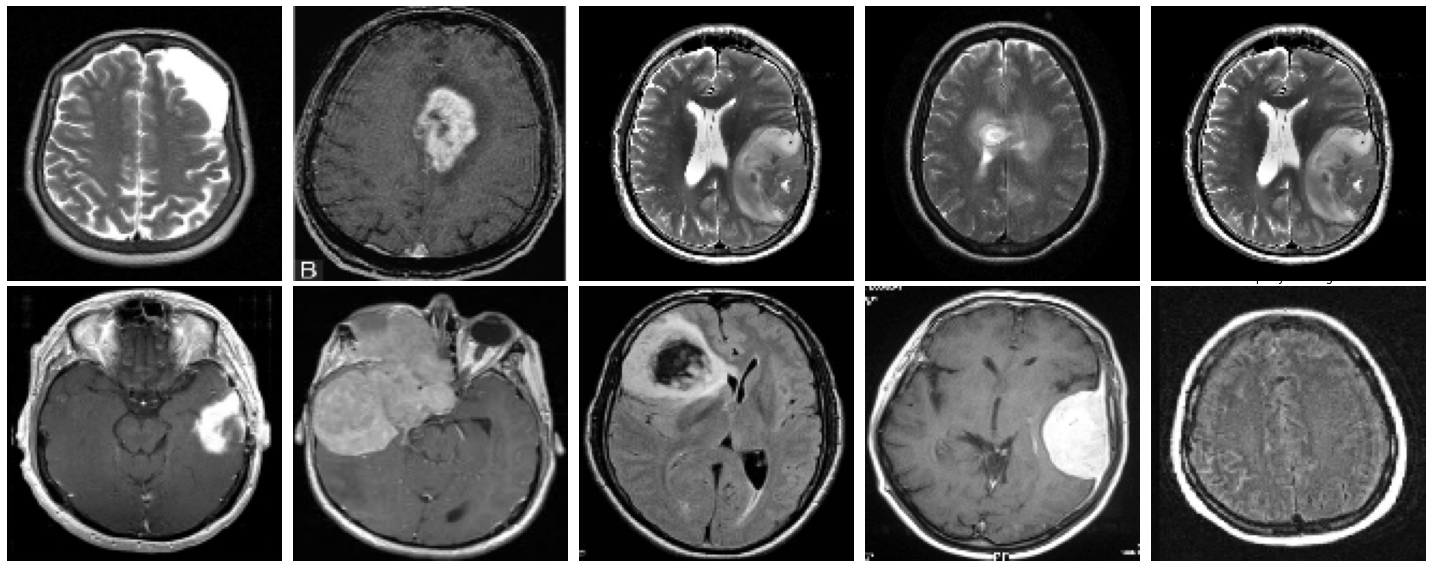


Building GAN for yes class...
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)     

Epoch 1/10: 100%|██████████| 1750/1750 [02:36<00:00, 11.21it/s]


EPOCH: 1 Generator Loss: 1.6857 Discriminator Loss: 0.4548


Epoch 2/10: 100%|██████████| 1750/1750 [02:26<00:00, 11.91it/s]


EPOCH: 2 Generator Loss: 2.2080 Discriminator Loss: 0.3314


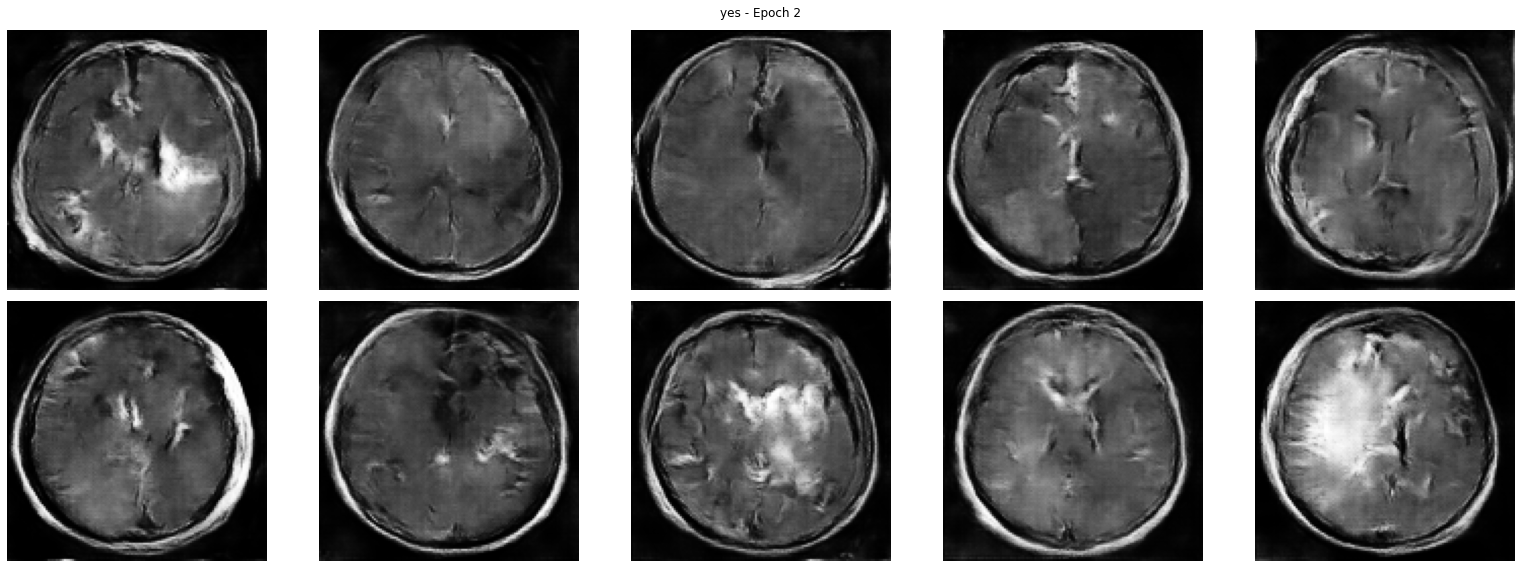

Epoch 3/10: 100%|██████████| 1750/1750 [02:28<00:00, 11.80it/s]


EPOCH: 3 Generator Loss: 2.8836 Discriminator Loss: 0.2412


Epoch 4/10: 100%|██████████| 1750/1750 [02:27<00:00, 11.84it/s]


EPOCH: 4 Generator Loss: 3.6922 Discriminator Loss: 0.1821


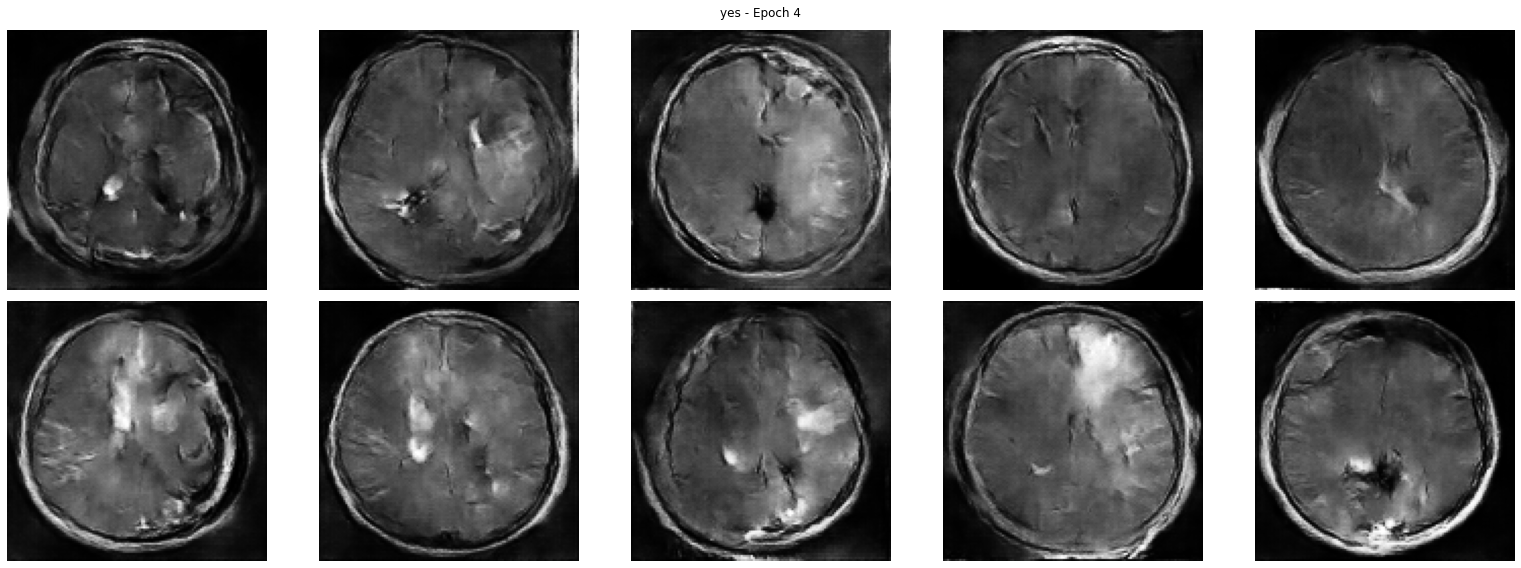

Epoch 5/10: 100%|██████████| 1750/1750 [02:26<00:00, 11.94it/s]


EPOCH: 5 Generator Loss: 4.2006 Discriminator Loss: 0.1509


Epoch 6/10: 100%|██████████| 1750/1750 [02:26<00:00, 11.95it/s]


EPOCH: 6 Generator Loss: 4.6871 Discriminator Loss: 0.1296


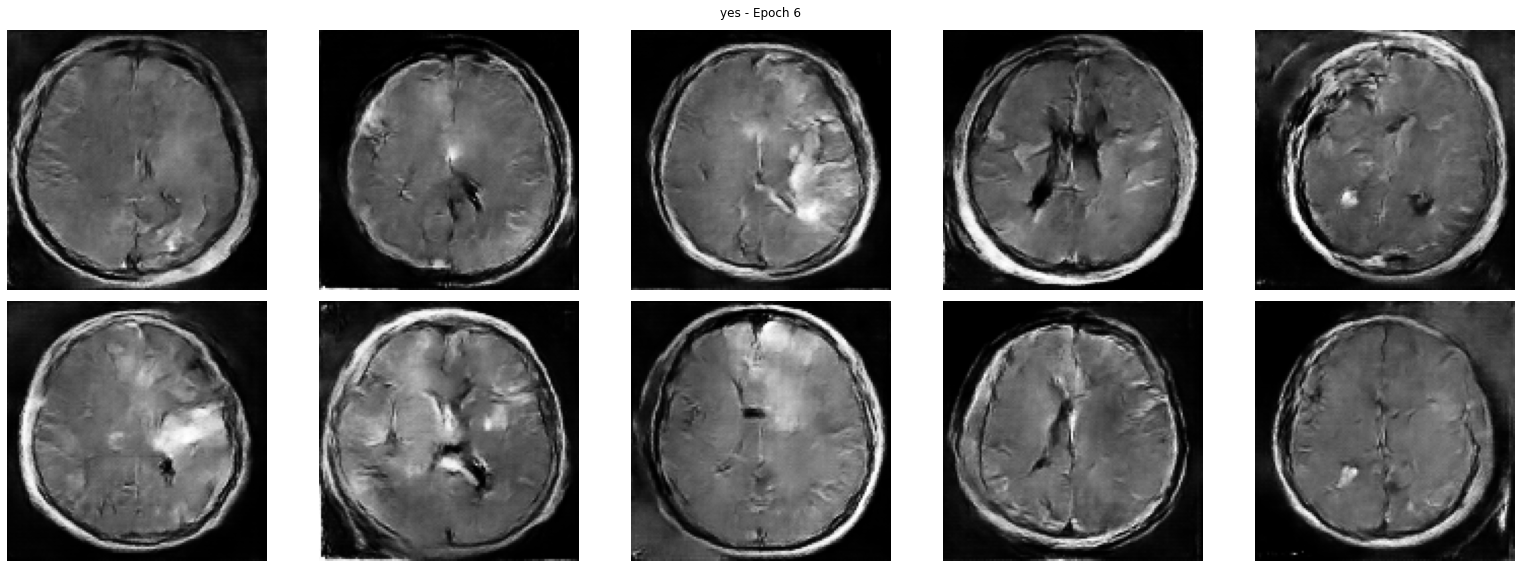

Epoch 7/10: 100%|██████████| 1750/1750 [02:27<00:00, 11.89it/s]


EPOCH: 7 Generator Loss: 5.1266 Discriminator Loss: 0.1129


Epoch 8/10: 100%|██████████| 1750/1750 [02:27<00:00, 11.88it/s]


EPOCH: 8 Generator Loss: 5.5732 Discriminator Loss: 0.0989


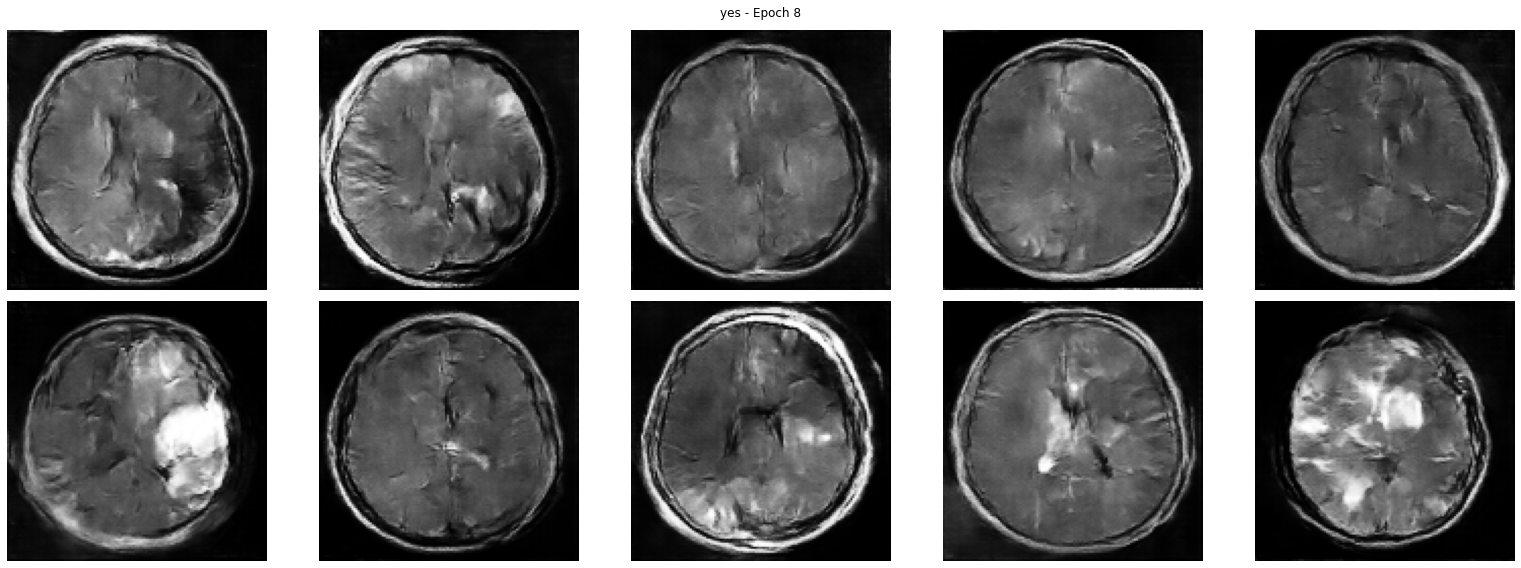

Epoch 9/10: 100%|██████████| 1750/1750 [02:27<00:00, 11.87it/s]


EPOCH: 9 Generator Loss: 5.9124 Discriminator Loss: 0.0911


Epoch 10/10: 100%|██████████| 1750/1750 [02:27<00:00, 11.86it/s]


EPOCH: 10 Generator Loss: 6.1331 Discriminator Loss: 0.0786


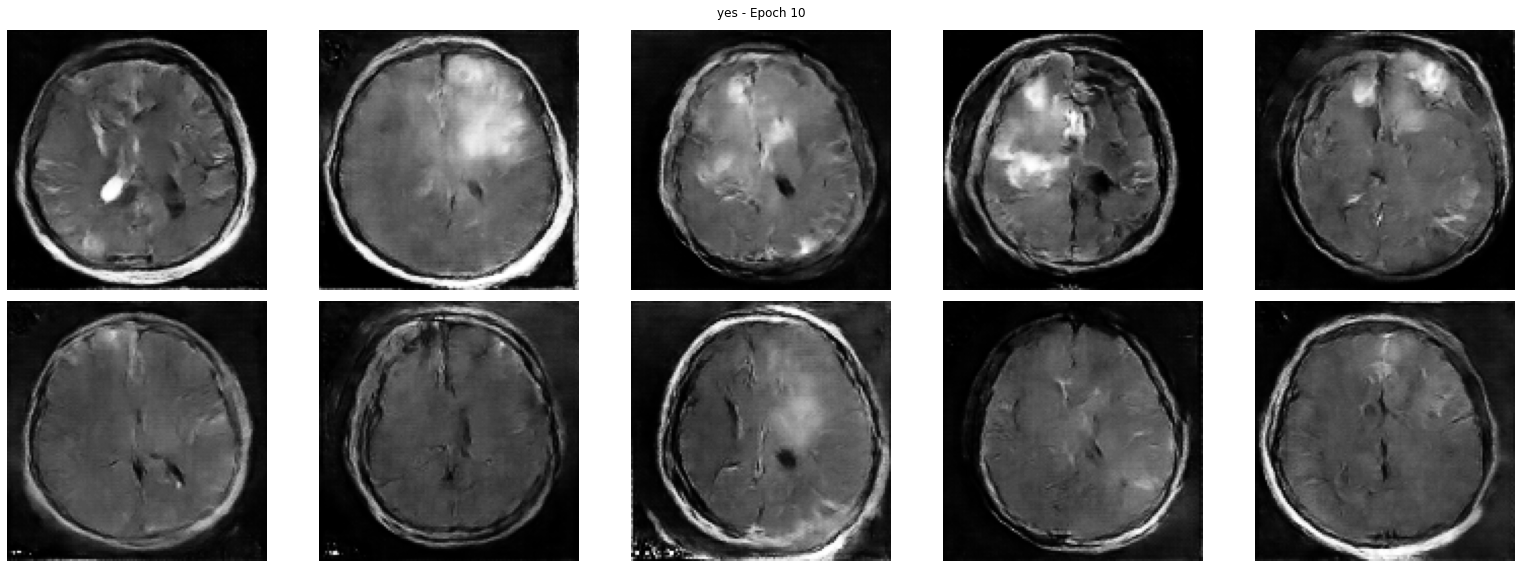

Generating synthetic yes images...


Generating yes images: 100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


Successfully generated and saved 2000 yes images to '/kaggle/working/yes' directory.
Generated array shape: (2000, 128, 128, 1)


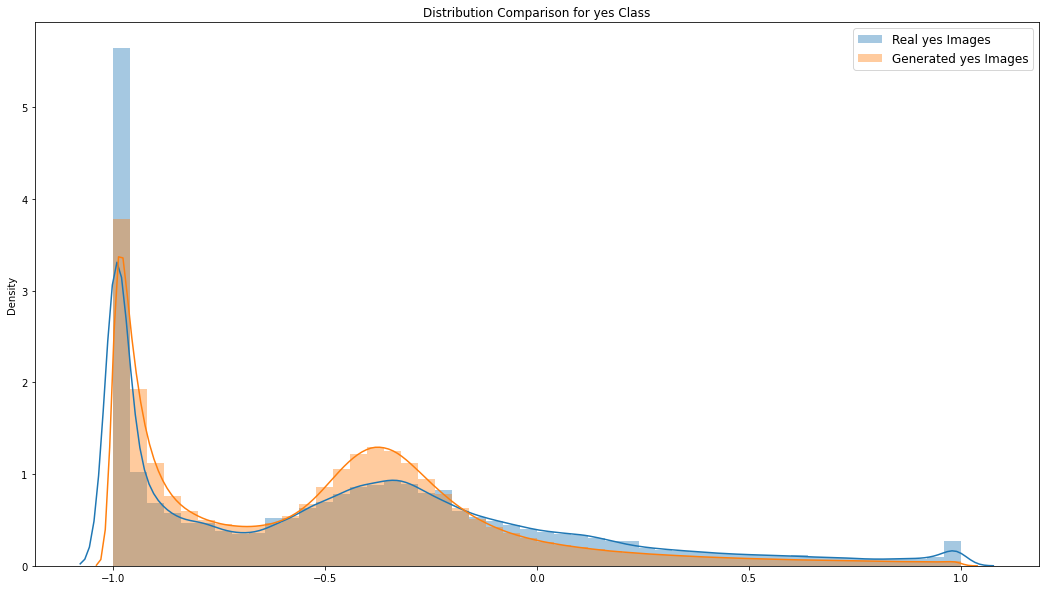


=== TRAINING NO CLASS (NO TUMOR) ===
Loading no class images from ../input/brain-mri-images-for-brain-tumor-detection/no...
Loaded 98 images for no class
Training data shape for no class: (98, 128, 128, 1)


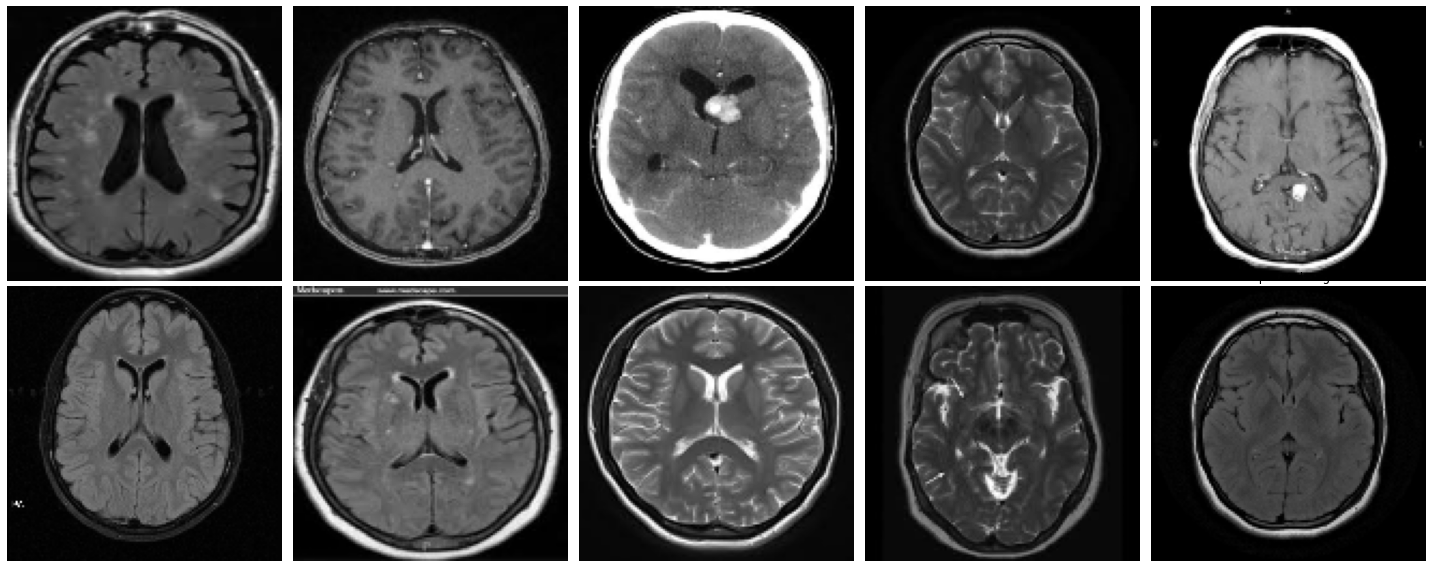


Building GAN for no class...
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 64)      640       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)      

Epoch 1/10: 100%|██████████| 1750/1750 [02:28<00:00, 11.77it/s]


EPOCH: 1 Generator Loss: 2.0344 Discriminator Loss: 0.4232


Epoch 2/10: 100%|██████████| 1750/1750 [02:27<00:00, 11.83it/s]


EPOCH: 2 Generator Loss: 2.6394 Discriminator Loss: 0.2423


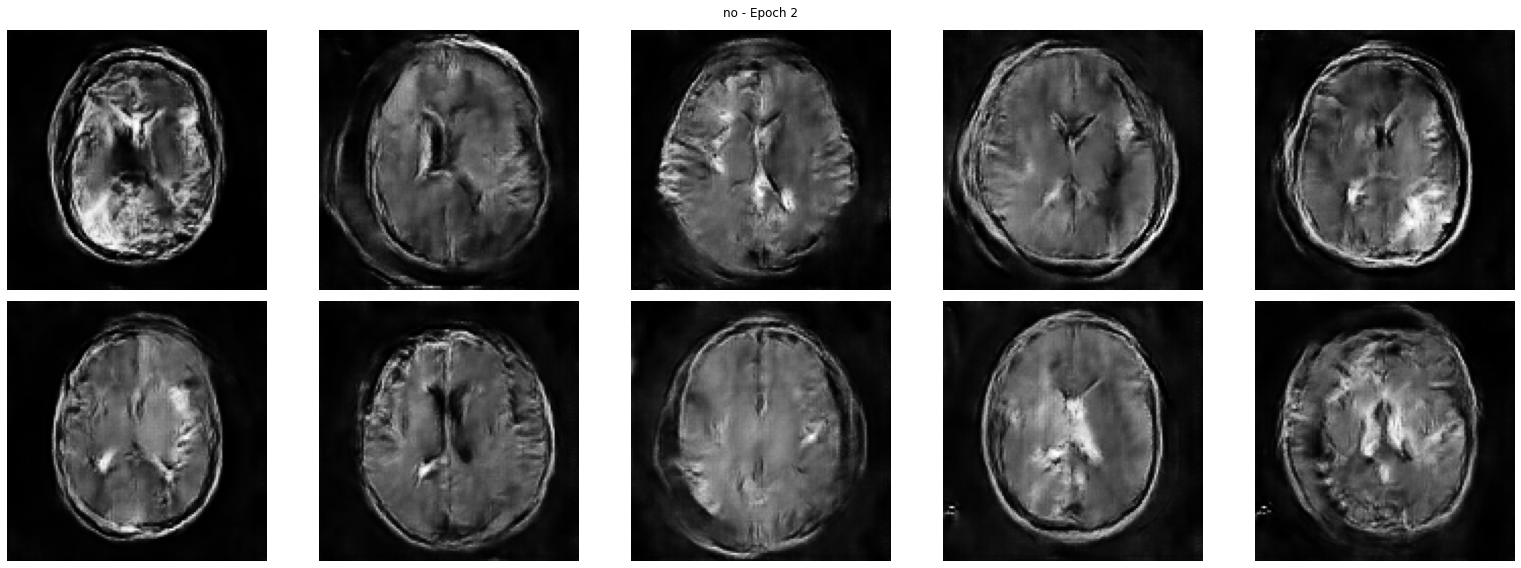

Epoch 3/10: 100%|██████████| 1750/1750 [02:29<00:00, 11.73it/s]


EPOCH: 3 Generator Loss: 3.5685 Discriminator Loss: 0.1543


Epoch 4/10: 100%|██████████| 1750/1750 [02:29<00:00, 11.73it/s]


EPOCH: 4 Generator Loss: 4.4420 Discriminator Loss: 0.1161


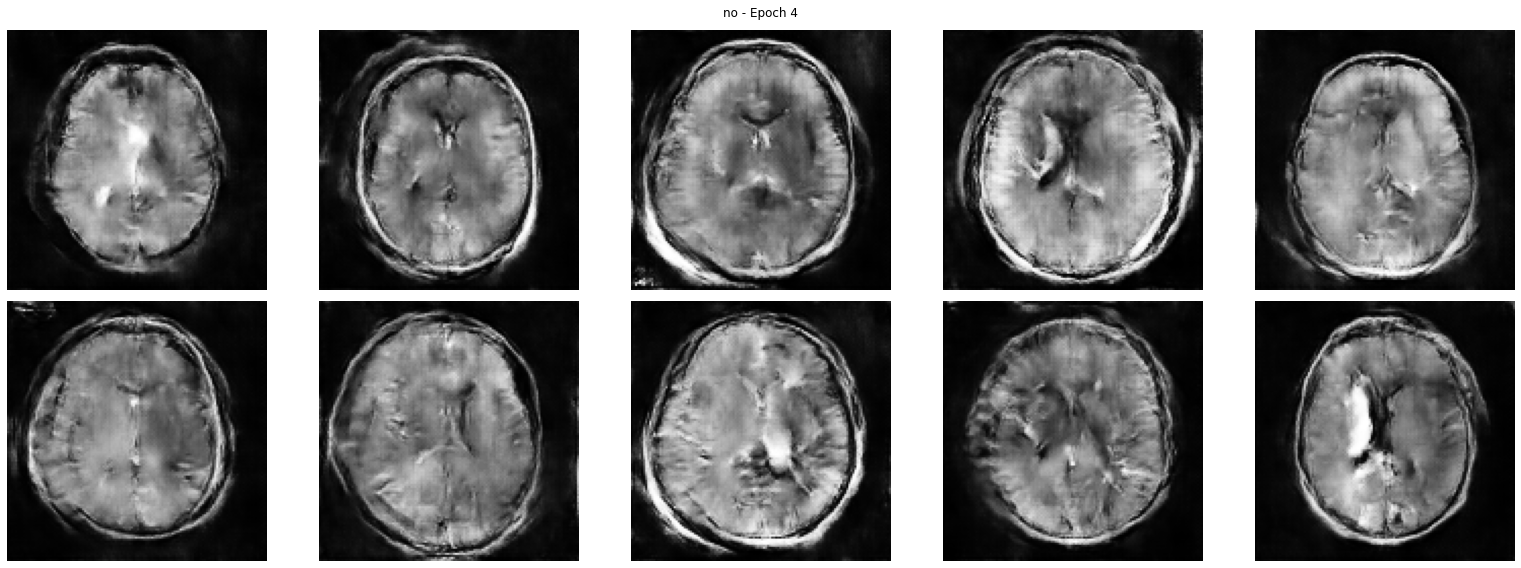

Epoch 5/10: 100%|██████████| 1750/1750 [02:28<00:00, 11.80it/s]


EPOCH: 5 Generator Loss: 5.1941 Discriminator Loss: 0.0852


Epoch 6/10: 100%|██████████| 1750/1750 [02:27<00:00, 11.84it/s]


EPOCH: 6 Generator Loss: 5.8582 Discriminator Loss: 0.0615


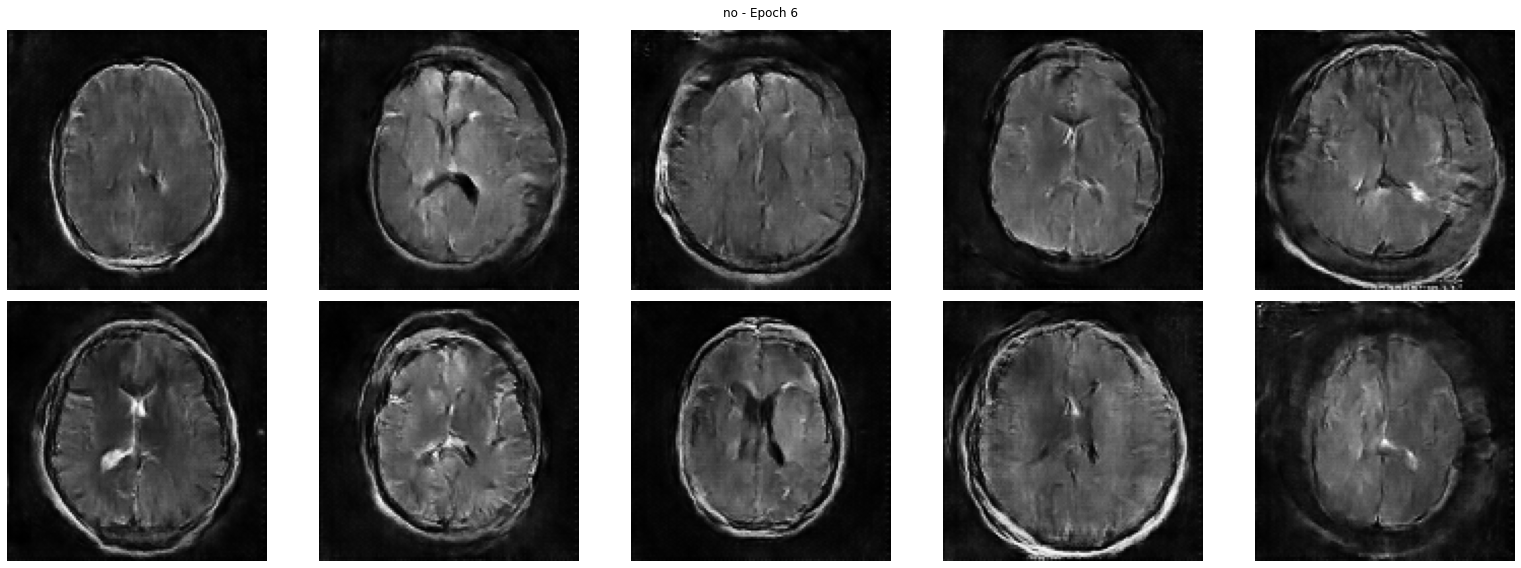

Epoch 7/10: 100%|██████████| 1750/1750 [02:28<00:00, 11.79it/s]


EPOCH: 7 Generator Loss: 6.1606 Discriminator Loss: 0.0743


Epoch 8/10: 100%|██████████| 1750/1750 [02:28<00:00, 11.77it/s]


EPOCH: 8 Generator Loss: 6.4427 Discriminator Loss: 0.0519


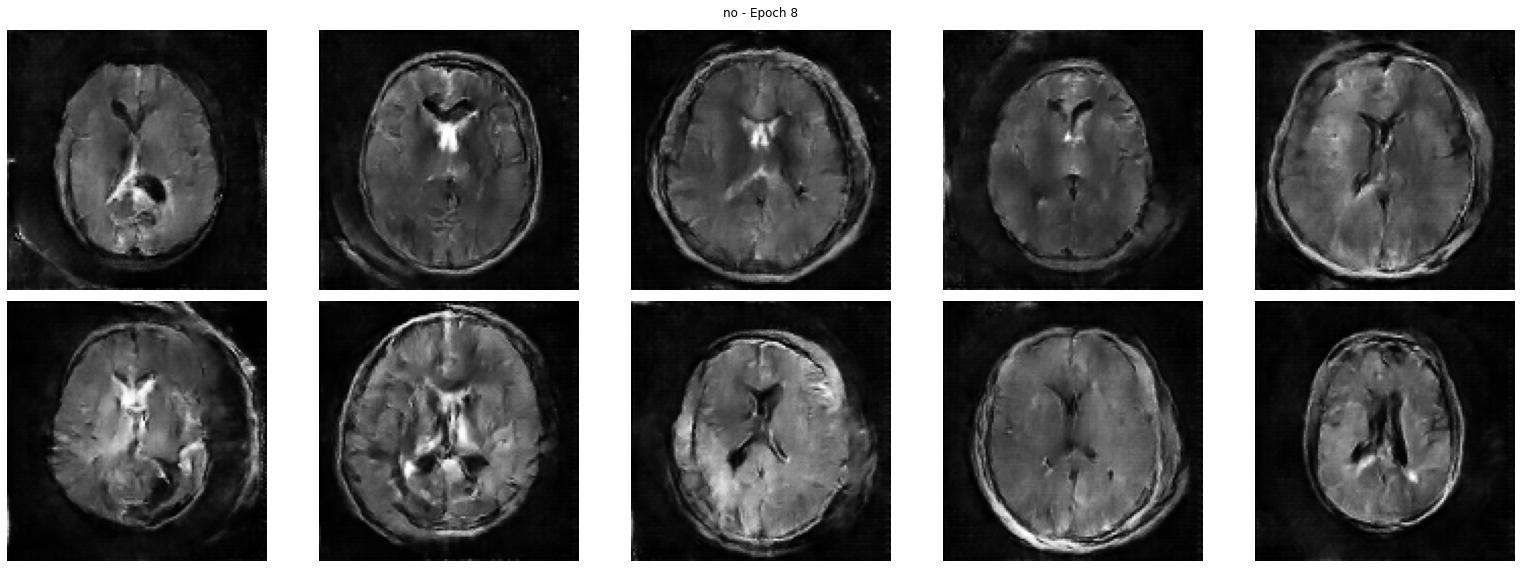

Epoch 9/10: 100%|██████████| 1750/1750 [02:29<00:00, 11.74it/s]


EPOCH: 9 Generator Loss: 7.1242 Discriminator Loss: 0.0680


Epoch 10/10: 100%|██████████| 1750/1750 [02:29<00:00, 11.68it/s]


EPOCH: 10 Generator Loss: 7.1241 Discriminator Loss: 0.0316


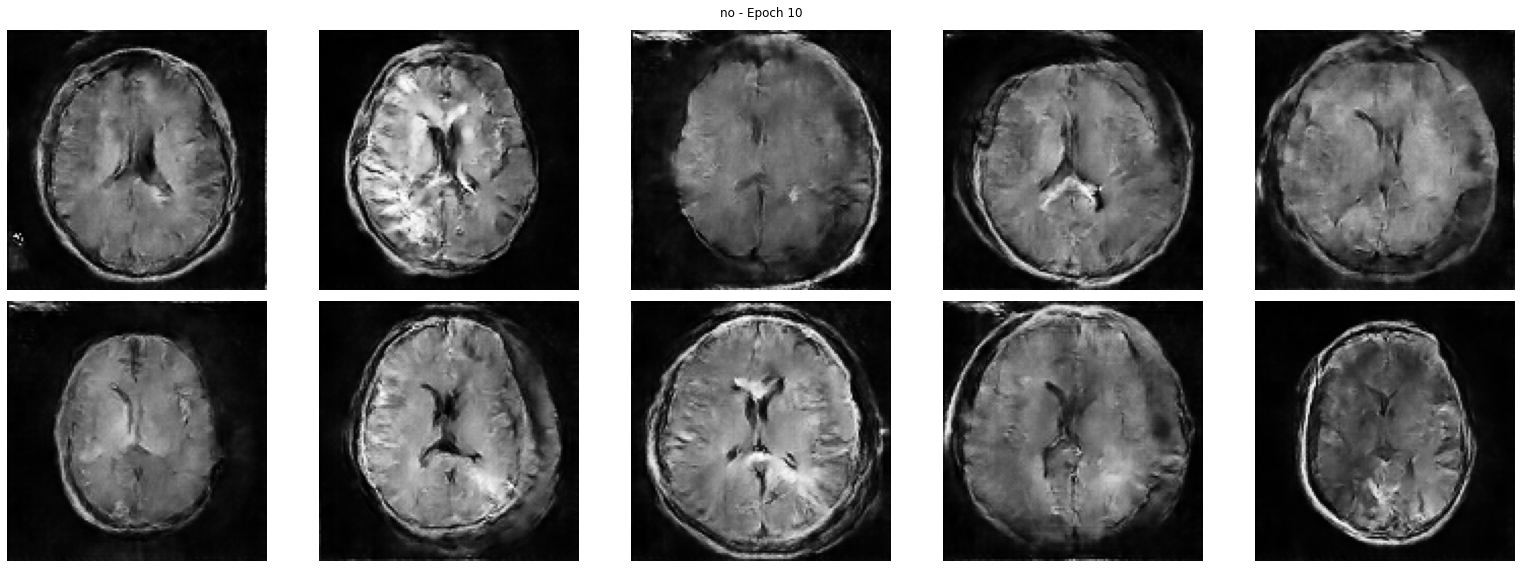

Generating synthetic no images...


Generating no images: 100%|██████████| 40/40 [00:04<00:00,  9.32it/s]


Successfully generated and saved 2000 no images to '/kaggle/working/no' directory.
Generated array shape: (2000, 128, 128, 1)


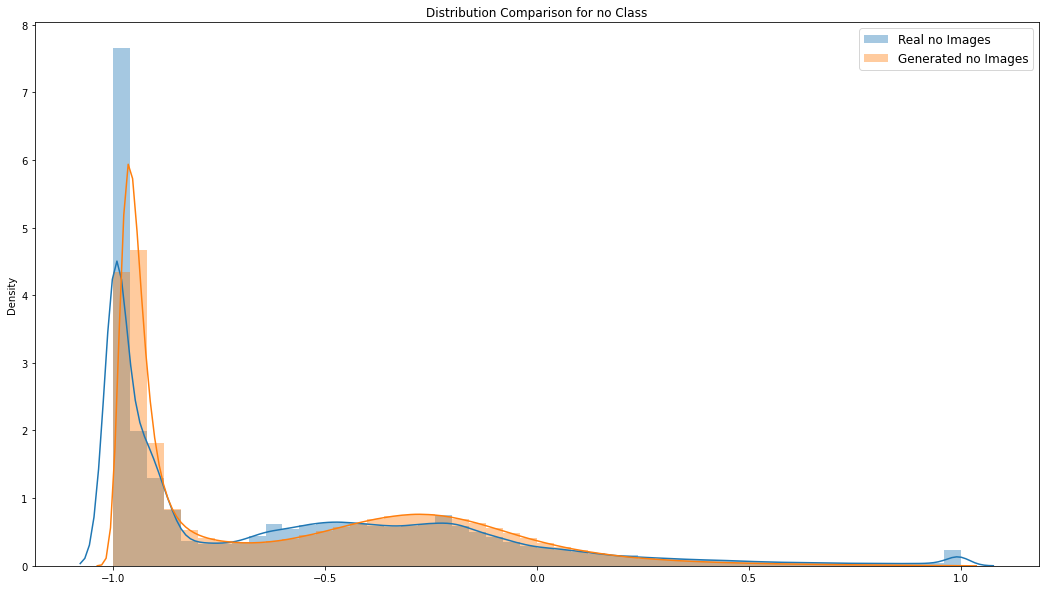

In [12]:
print("=== TRAINING YES CLASS (TUMOR) ===")
synthetic_yes_images = train_and_generate(YES_DIR, yes_output_dir, "yes")

print("\n=== TRAINING NO CLASS (NO TUMOR) ===")
synthetic_no_images = train_and_generate(NO_DIR, no_output_dir, "no")

In [13]:
def augment_image(image_path, output_dir, index, class_label):
    """Apply augmentation techniques to an image and save results"""
    
    original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original_img is None:
        print(f"Warning: Could not read image {image_path}")
        return 0
    
    
    cv2.imwrite(f"{output_dir}/original_{class_label}_{index}.png", original_img)
    
    
    augmentations = []
    
    
    flipped_h = cv2.flip(original_img, 1)
    cv2.imwrite(f"{output_dir}/flipped_h_{class_label}_{index}.png", flipped_h)
    augmentations.append(("Horizontal Flip", flipped_h))
    
    
    flipped_v = cv2.flip(original_img, 0)
    cv2.imwrite(f"{output_dir}/flipped_v_{class_label}_{index}.png", flipped_v)
    augmentations.append(("Vertical Flip", flipped_v))
    
    
    rotated_90 = cv2.rotate(original_img, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite(f"{output_dir}/rotated_90_{class_label}_{index}.png", rotated_90)
    augmentations.append(("90° Rotation", rotated_90))
    
   
    rotated_180 = cv2.rotate(original_img, cv2.ROTATE_180)
    cv2.imwrite(f"{output_dir}/rotated_180_{class_label}_{index}.png", rotated_180)
    augmentations.append(("180° Rotation", rotated_180))
    
    return len(augmentations)

In [14]:
print("\n=== APPLYING AUGMENTATION TO BOTH CLASSES ===")
total_original = 0
total_augmented = 0


yes_image_files = [f for f in os.listdir(yes_output_dir) if f.endswith(".jpg")]
print(f"Found {len(yes_image_files)} generated YES class images to process")

for i, img_file in enumerate(tqdm(yes_image_files, desc="Augmenting YES Images")):
    img_path = os.path.join(yes_output_dir, img_file)
    total_original += 1
    num_augmented = augment_image(img_path, augmented_dir, i, "yes")
    total_augmented += num_augmented


no_image_files = [f for f in os.listdir(no_output_dir) if f.endswith(".jpg")]
print(f"Found {len(no_image_files)} generated NO class images to process")

for i, img_file in enumerate(tqdm(no_image_files, desc="Augmenting NO Images")):
    img_path = os.path.join(no_output_dir, img_file)
    total_original += 1
    num_augmented = augment_image(img_path, augmented_dir, i + len(yes_image_files), "no")
    total_augmented += num_augmented

print(f"Augmentation complete. Generated {total_augmented} augmented images from {total_original} original images.")


=== APPLYING AUGMENTATION TO BOTH CLASSES ===
Found 2000 generated YES class images to process


Augmenting YES Images: 100%|██████████| 2000/2000 [00:03<00:00, 515.92it/s]


Found 2000 generated NO class images to process


Augmenting NO Images: 100%|██████████| 2000/2000 [00:03<00:00, 511.15it/s]

Augmentation complete. Generated 16000 augmented images from 4000 original images.


In [16]:
#cnn parameters
WIDTH, HEIGHT = 128, 128
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

In [17]:
AUGMENTED_DIR = "/kaggle/working/augmented_images"
RESULTS_DIR = "/kaggle/working/results"
MODEL_DIR = "/kaggle/working/logs"

In [18]:
def load_augmented_data(augmented_dir):
    """Load all augmented images and their corresponding labels"""
    images = []
    labels = []
    
    print("Loading augmented images...")
    for img_file in tqdm(os.listdir(augmented_dir)):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            
            is_tumor = 1 if "yes" in img_file else 0
            
            img_path = os.path.join(augmented_dir, img_file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (WIDTH, HEIGHT))
                
                
                img = img / 255.0
                
                images.append(img)
                labels.append(is_tumor)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
   
    X = np.array(images).reshape(-1, WIDTH, HEIGHT, 1)
    y = np.array(labels)
    
    print(f"Loaded {len(images)} images with shape {X.shape}")
    print(f"Class distribution: {np.bincount(y)}")
    
    return X, y

In [19]:
def build_cnn_model():
    """Build a CNN model for classification"""
    model = Sequential([
        
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(WIDTH, HEIGHT, 1)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        r
        Dense(1, activation='sigmoid')
    ])
    
   
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy', 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

In [20]:
def visualize_training_history(history):
    """Visualize training metrics"""
    
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
    
    fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))
    
    for i, metric in enumerate(metrics):
        axs[i].plot(history.history[metric], label=f'Training {metric}')
        if f'val_{metric}' in history.history:
            axs[i].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        
        axs[i].set_title(f'{metric.capitalize()} Over Epochs')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend()
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'training_history.png'))
    plt.show()

In [21]:
def visualize_confusion_matrix(y_true, y_pred, classes=['No Tumor', 'Tumor']):
    """Create and visualize normalized confusion matrix"""
   
    cm = confusion_matrix(y_true, np.round(y_pred))
    
  
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix.png'))
    plt.show()
    
    
    print("Confusion Matrix (Raw Counts):")
    print(cm)

In [22]:
def visualize_roc_curve(y_true, y_pred_prob):
    """Create and visualize ROC curve"""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'roc_curve.png'))
    plt.show()


In [23]:
def visualize_precision_recall_curve(y_true, y_pred_prob):
    """Create and visualize precision-recall curve"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (area = {pr_auc:.3f})')
    plt.axhline(y=np.sum(y_true) / len(y_true), color='navy', lw=2, linestyle='--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'precision_recall_curve.png'))
    plt.show()

In [ ]:
def visualize_sample_predictions(X_test, y_test, predictions, num_samples=10):
    """Visualize sample predictions for test data"""
    indices = np.random.choice(range(len(X_test)), min(num_samples, len(X_test)), replace=False)
    
    plt.figure(figsize=(20, 8))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[idx].reshape(WIDTH, HEIGHT), cmap='gray')
        
        true_label = "Tumor" if y_test[idx] == 1 else "No Tumor"
        pred_label = "Tumor" if predictions[idx][0] > 0.5 else "No Tumor"
        
        
        color = "green" if true_label == pred_label else "red"
        
        plt.title(f"True: {true_label}\nPred: {pred_label} ({predictions[idx][0]:.2f})", 
                  color=color, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'sample_predictions.png'))
    plt.show()

In [28]:
X, y = load_augmented_data(AUGMENTED_DIR)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=TEST_SPLIT, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=VALIDATION_SPLIT, stratify=y_train_val, random_state=42
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")


Loading augmented images...


100%|██████████| 20000/20000 [00:07<00:00, 2649.44it/s]


Loaded 20000 images with shape (20000, 128, 128, 1)
Class distribution: [10000 10000]
Training set: 14400 images
Validation set: 3600 images
Test set: 2000 images


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE
)

validation_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=BATCH_SIZE
)


model = build_cnn_model()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 64)        1

In [30]:
callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]


print("\nTraining CNN model...")
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(X_val) // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)


print("\nEvaluating model on test set...")
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Training CNN model...
Epoch 1/20
450/450 [==============================] - 23s 46ms/step - loss: 0.1797 - accuracy: 0.9299 - precision: 0.9303 - recall: 0.9293 - auc: 0.9811 - val_loss: 1.7391 - val_accuracy: 0.5307 - val_precision: 0.6030 - val_recall: 0.1797 - val_auc: 0.5722

Epoch 00001: val_accuracy improved from -inf to 0.53069, saving model to /kaggle/working/logs/best_model.h5
Epoch 2/20
450/450 [==============================] - 20s 45ms/step - loss: 0.0602 - accuracy: 0.9780 - precision: 0.9801 - recall: 0.9758 - auc: 0.9973 - val_loss: 8.3398 - val_accuracy: 0.5006 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5031

Epoch 00002: val_accuracy did not improve from 0.53069
Epoch 3/20
450/450 [==============================] - 20s 45ms/step - loss: 0.0479 - accuracy: 0.9825 - precision: 0.9842 - recall: 0.9807 - auc: 0.9982 - val_loss: 3.1216 - val_accuracy: 0.5541 - val_precision: 1.0000 - val_recall: 0.1097 - val_auc: 0.7270

Epoch 00003: val_accuracy imp


Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.98      1.00      0.99      1000
       Tumor       1.00      0.98      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000


Visualizing training history...


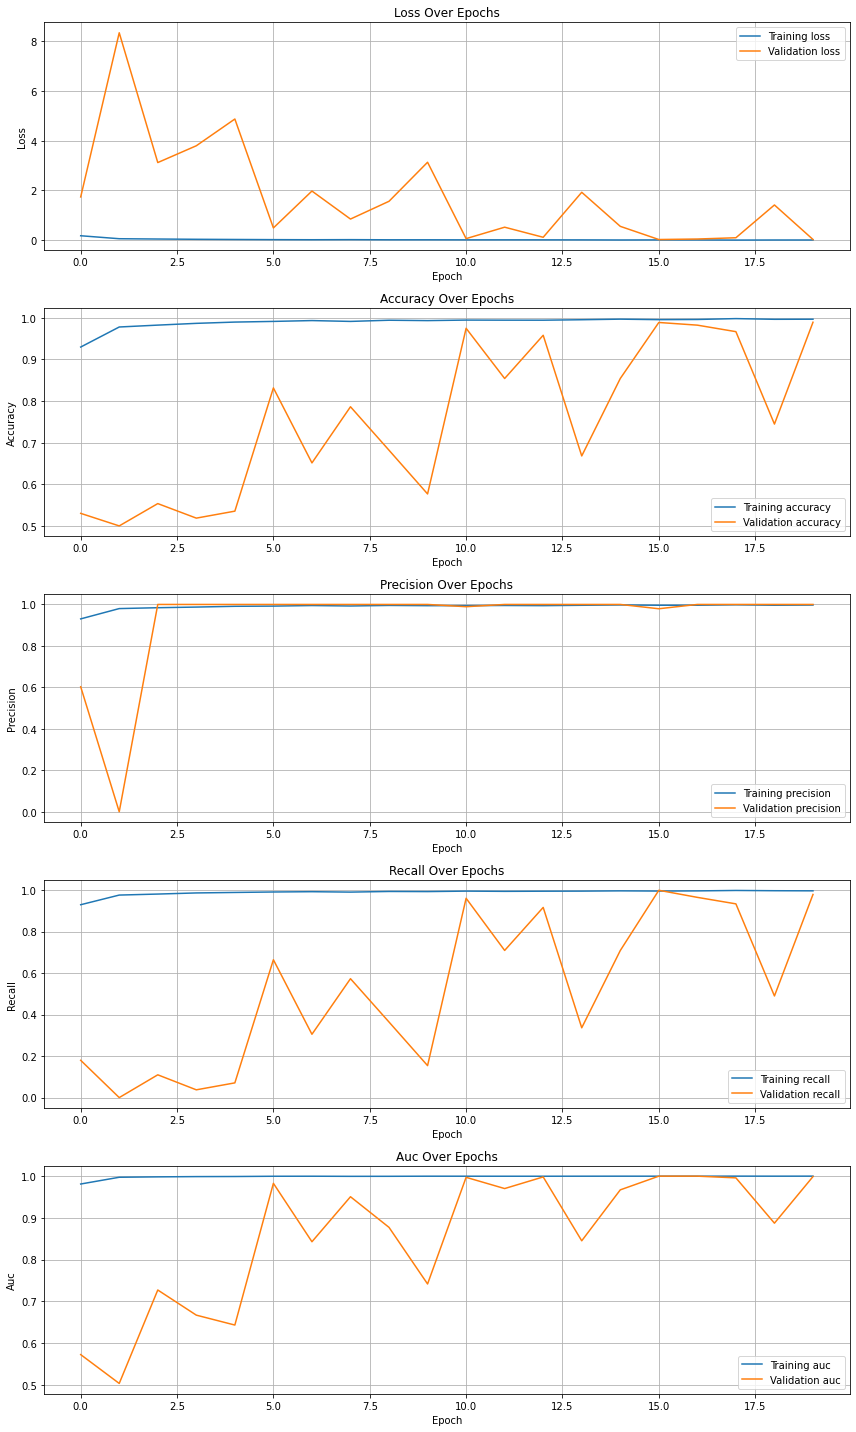


Visualizing confusion matrix...


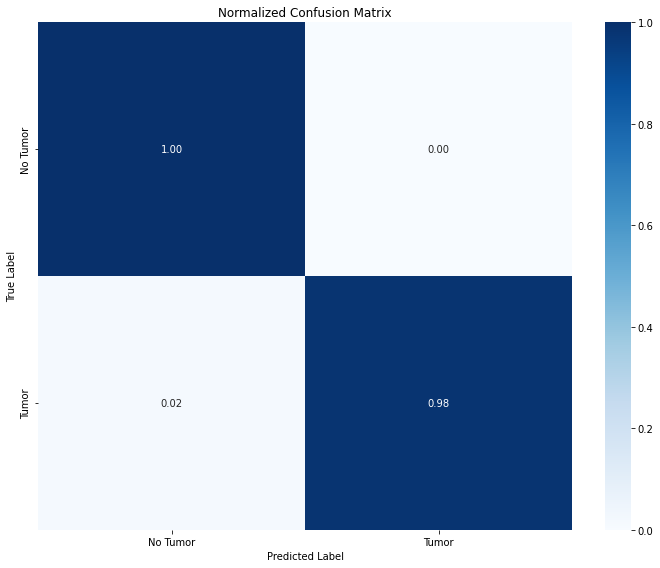

Confusion Matrix (Raw Counts):
[[1000    0]
 [  18  982]]

Visualizing sample predictions...


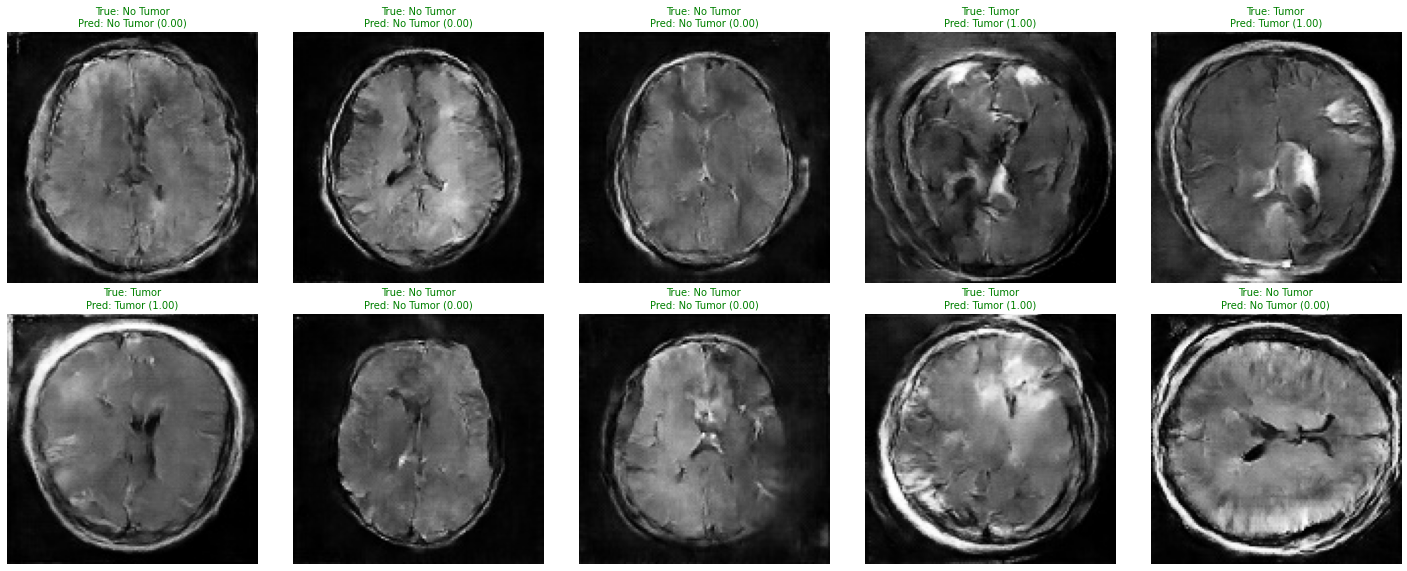

In [33]:
y_pred_prob = model.predict(X_test)
y_pred = np.round(y_pred_prob)


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Tumor', 'Tumor']))


print("\nVisualizing training history...")
visualize_training_history(history)


print("\nVisualizing confusion matrix...")
visualize_confusion_matrix(y_test, y_pred_prob)



print("\nVisualizing sample predictions...")
visualize_sample_predictions(X_test, y_test, y_pred_prob)
